MACS 30100 PS3 Fangfang Wan

Question 1

In [1]:
# Import packages and load the data
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import math
cmap1 = matplotlib.cm.get_cmap('summer')
# This next command is specifically for Jupyter Notebook
%matplotlib notebook
income = np.loadtxt('incomes.txt')

In [2]:
def trunc_norm_pdf(xvals, mu, sigma, cutoff):
    '''
    --------------------------------------------------------------------
    Generate pdf values from the truncated normal pdf with mean mu and
    standard deviation sigma. If the cutoff is finite, then the PDF
    values are inflated upward to reflect the zero probability on values
    above the cutoff. If there is no cutoff given or if it is given as
    infinity, this function does the same thing as
    sp.stats.norm.pdf(x, loc=mu, scale=sigma).
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, values of the normally distributed random
             variable
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    prob_notcut = scalar 
    pdf_vals = (N,) vector, normal PDF values for mu and sigma
               corresponding to xvals data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: pdf_vals
    --------------------------------------------------------------------
    '''
    if cutoff == 'None':
        prob_notcut = 1.0 - sts.norm.cdf(0, loc=mu, scale=sigma)
    else:
        prob_notcut = (sts.norm.cdf(cutoff, loc=mu, scale=sigma) -
                       sts.norm.cdf(0, loc=mu, scale=sigma))
            
    pdf_vals = ((1/(xvals * sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))) /
                    prob_notcut)
    
    return pdf_vals

In [3]:
def data_moments(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the two data moments for GMM
    (mean(data), standard deviation(data)).
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, test scores data
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data = scalar, mean value of test scores data
    sd_data  = scalar > 0, standard deviation of test scores data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mean_data, sd_data
    --------------------------------------------------------------------
    '''
    mean_data = xvals.mean()
    sd_data = math.sqrt(xvals.var())
    
    return mean_data, sd_data


def model_moments(mu, sigma, cutoff):
    '''
    --------------------------------------------------------------------
    This function computes the two model moments for GMM
    (mean(model data), standard deviation(model data)).
    --------------------------------------------------------------------
    INPUTS:
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        trunc_norm_pdf()
        xfx()
        x2fx()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_model = scalar, mean value of test scores from model
    m_m_err    = scalar > 0, estimated error in the computation of the
                 integral for the mean of the distribution
    sd_model  = scalar > 0, standard deviation of test scores from model
    v_m_err    = scalar > 0, estimated error in the computation of the
                 integral for the variance of the distribution
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mean_model, sd_model
    --------------------------------------------------------------------
    '''
    xfx = lambda x: x * trunc_norm_pdf(x, mu, sigma, cutoff)
    (mean_model, m_m_err) = intgr.quad(xfx, 1e-10, cutoff)
    x2fx = lambda x: ((x - mean_model) ** 2) * trunc_norm_pdf(x, mu, sigma, cutoff) 
    (var_model, v_m_err) = intgr.quad(x2fx, 1e-10, cutoff)
    sd_model = math.sqrt(var_model)
    
    return mean_model, sd_model


def err_vec(xvals, mu, sigma, cutoff, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        data_moments()
        model_moments()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data  = scalar, mean value of data
    sd_data   = scalar > 0, standard deviation of data
    moms_data  = (2, 1) matrix, column vector of two data moments
    mean_model = scalar, mean value from model
    sd_model  = scalar > 0, standard deviation from model
    moms_model = (2, 1) matrix, column vector of two model moments
    err_vec    = (2, 1) matrix, column vector of two moment error
                 functions
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    mean_data, sd_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [sd_data]])
    mean_model, sd_model = model_moments(mu, sigma, cutoff)
    moms_model = np.array([[mean_model], [sd_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


def criterion(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 3 tuple, (xvals, cutoff, W_hat)
    xvals  = (N,) vector, values of the truncated normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        norm_pdf()
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (2, 1) matrix, column vector of two moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, cutoff, W = args
    err = err_vec(xvals, mu, sigma, cutoff, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val


(a)

<IPython.core.display.Javascript object>


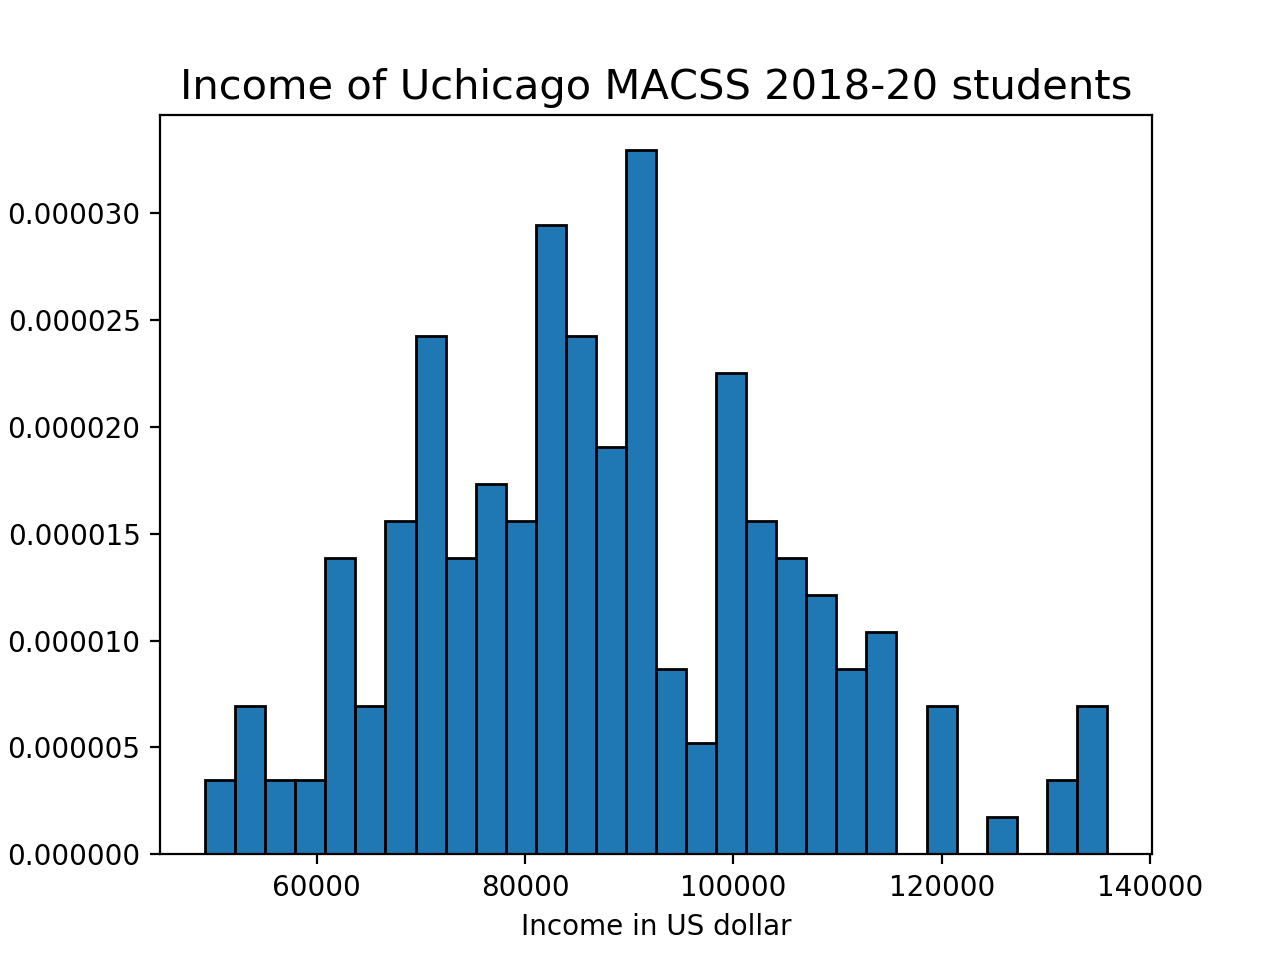

Text(0,0.5,'Percent of students')

In [4]:
import matplotlib.pyplot as plt
%matplotlib notebook
count, bins, ignored = plt.hist(income, 30, edgecolor='black', normed=True)
plt.title('Income of Uchicago MACSS 2018-20 students', fontsize=15)
plt.xlabel('Income in US dollar')
plt.ylabel('Percent of students')

(b)

In [5]:
# Note that this takes a little time because the intgr.quad() commands
# are a little slow
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (income, 150000, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)

mu_GMM1= 11.3660505197  sig_GMM1= 0.208759131345


In [6]:
mean_data, sd_data = data_moments(income)
mean_model, sd_model = model_moments(mu_GMM1, sig_GMM1, 150000)
err1 = err_vec(income, mu_GMM1, sig_GMM1, 150000, False).reshape(2,)
print('Mean of Income =', mean_data, ', standard deviation of Income =', sd_data)
print('Mean of model =', mean_model, ', standard deviation of model =', sd_model)
print('Error vector=', err1)
results

Mean of Income = 87588.9307685 , standard deviation of Income = 18035.906827092327
Mean of model = 87588.90966253178 , standard deviation of model = 18035.90417588697
Error vector= [ -2.40966301e-07  -1.46995955e-07]


      fun: array([[  7.96725690e-14]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -6.17010612e-07,  -1.00771499e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 51
      nit: 10
   status: 0
  success: True
        x: array([ 11.36605052,   0.20875913])

<IPython.core.display.Javascript object>


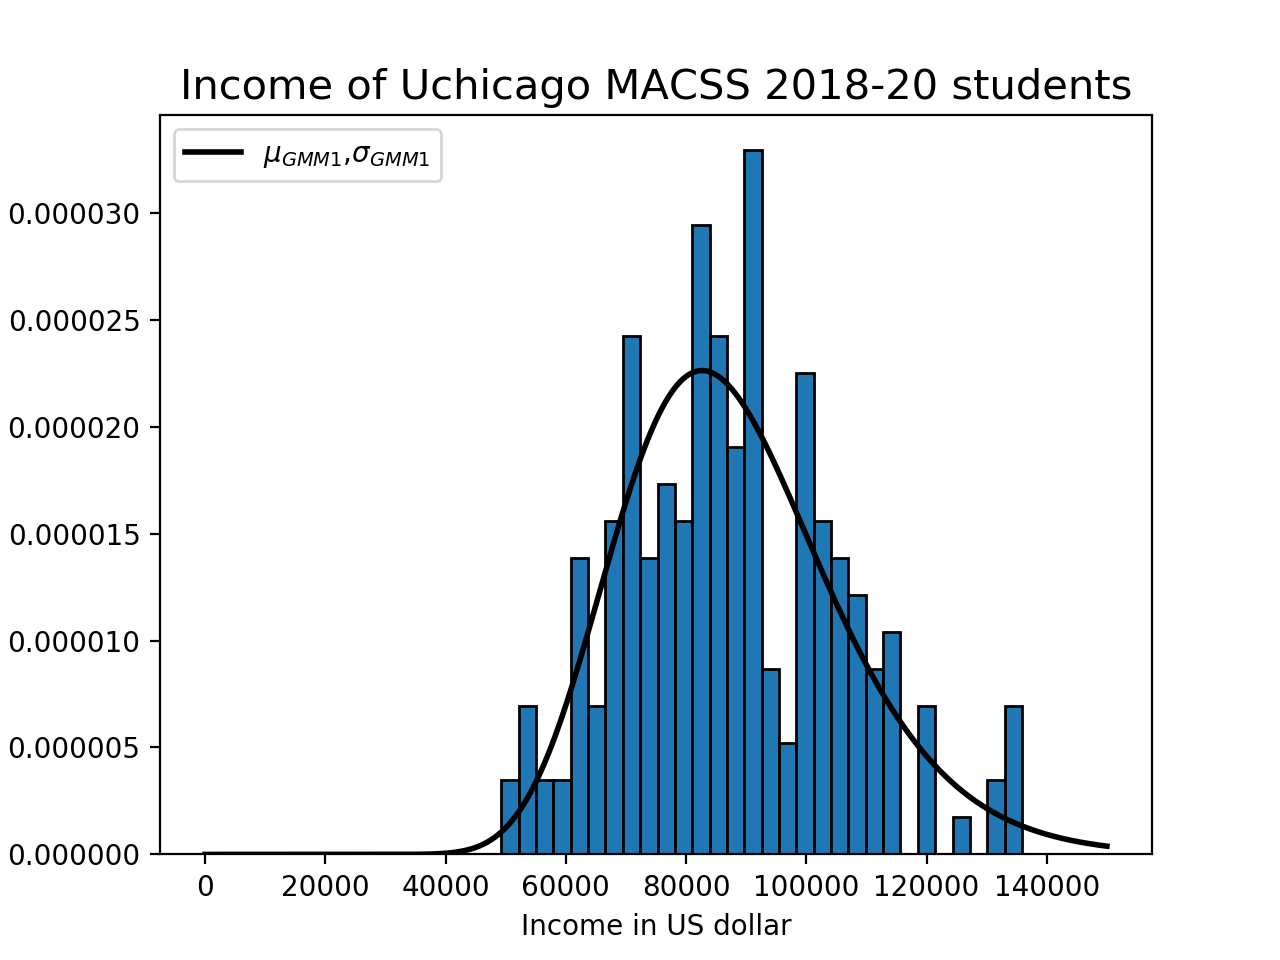

In [7]:

# histogram from part(a)
%matplotlib notebook
count, bins, ignored = plt.hist(income, 30, edgecolor='black', normed=True)
plt.title('Income of Uchicago MACSS 2018-20 students', fontsize=15)
plt.xlabel('Income in US dollar')
plt.ylabel('Percent of students')


# Plot the GMM estimated distribution
dist_pts = np.linspace(1e-10, 150000, 500)
plt.plot(dist_pts, trunc_norm_pdf(dist_pts, mu_GMM1, sig_GMM1, 150000),
         linewidth=2, color='k', label='$\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc='upper left')

In [8]:
crit_val = criterion(np.array([mu_GMM1, sig_GMM1]), income, 150000, W_hat)
print("The value of GMM criterion function is", crit_val)

The value of GMM criterion function is [[  7.96725690e-14]]


In [9]:
data_mean, data_sd = data_moments(income)
mean_model, sd_model = model_moments(mu_GMM1, sig_GMM1, 150000)
print("As for data moments, data mean is", data_mean, ", data standard deviation is", data_sd)
print("As for model moments, model mean is", mean_model, ", data standard deviation is", sd_model)

As for data moments, data mean is 87588.9307685 , data standard deviation is 18035.906827092327
As for model moments, model mean is 87588.90966253178 , data standard deviation is 18035.90417588697


(c)

In [10]:
err1 = err_vec(income, mu_GMM1, sig_GMM1, 150000, False)
VCV2 = np.dot(err1, err1.T) / income.shape[0]
print("The variance-covariance matrix is", VCV2)
W_hat2 = lin.pinv(VCV2)  # Use the pseudo-inverse calculated by SVD because VCV2 is ill-conditioned
print("The two-step estimator for the optimal weighting matrix is", W_hat2)

The variance-covariance matrix is [[  2.90323790e-16   1.77105358e-16]
 [  1.77105358e-16   1.08039055e-16]]
The two-step estimator for the optimal weighting matrix is [[  1.82946866e+15   1.11602532e+15]
 [  1.11602532e+15   6.80805608e+14]]


In [11]:
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_GMM1, sig_GMM1])
# W_hat3 = np.array([[1. / VCV2[0, 0], 0.], [0., 1. / VCV2[1, 1]]])
gmm_args = (income, 150000, W_hat2)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results.x
print('mu_GMM2=', mu_GMM2, ' sig_GMM2=', sig_GMM2)

/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars
/Users/apple/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


mu_GMM2= 11.3660505749  sig_GMM2= 0.208759232867


In [12]:
crit_val_2 = criterion(np.array([mu_GMM2, sig_GMM2]), income, 150000, W_hat2)
print("The value of GMM criterion function is", crit_val_2)

The value of GMM criterion function is [[ 0.19506782]]


<IPython.core.display.Javascript object>


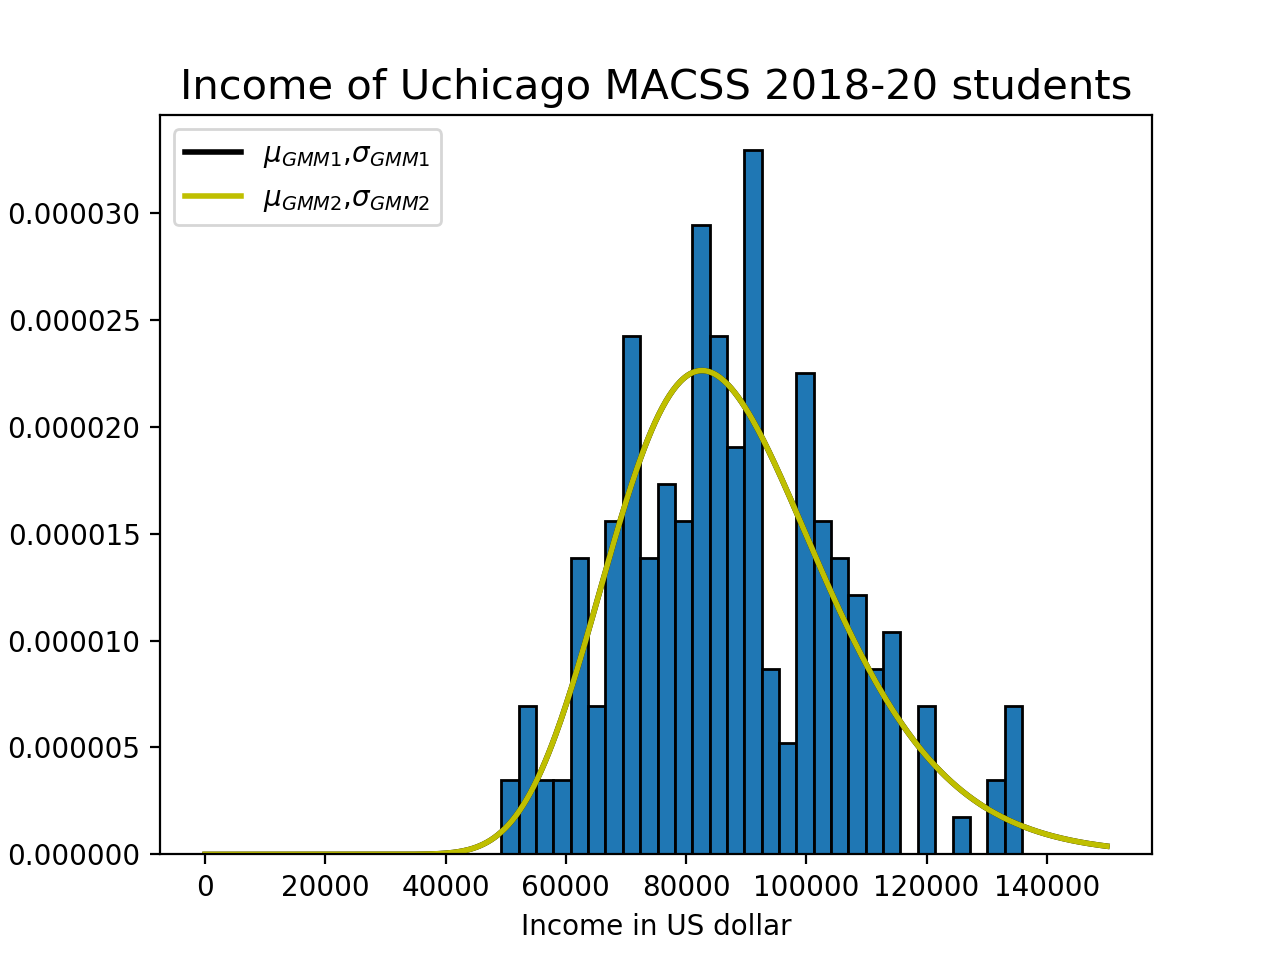

In [26]:
# histogram from part(a)
%matplotlib notebook
count, bins, ignored = plt.hist(income, 30, edgecolor='black', normed=True)
plt.title('Income of Uchicago MACSS 2018-20 students', fontsize=15)
plt.xlabel('Income in US dollar')
plt.ylabel('Percent of students')


# Plot the GMM estimated distribution from part (b)
dist_pts = np.linspace(1e-10, 150000, 500)
plt.plot(dist_pts, trunc_norm_pdf(dist_pts, mu_GMM1, sig_GMM1, 150000),
         linewidth=2, color='k', label='$\mu_{GMM1}$,$\sigma_{GMM1}$')
plt.legend(loc='upper left')

# Plot the two-step GMM estimated distribution
dist_pts = np.linspace(1e-10, 150000, 500)
plt.plot(dist_pts, trunc_norm_pdf(dist_pts, mu_GMM2, sig_GMM2, 150000),
         linewidth=2, color='y', label='$\mu_{GMM2}$,$\sigma_{GMM2}$')
plt.legend(loc='upper left')

In [14]:
data_mean, data_sd = data_moments(income)
mean_model, sd_model = model_moments(mu_GMM2, sig_GMM2, 150000)
print("As for data moments, data mean is", data_mean, ", data standard deviation is", data_sd)
print("As for model moments, model mean is", mean_model, ", model standard deviation is", sd_model)

As for data moments, data mean is 87588.9307685 , data standard deviation is 18035.906827092327
As for model moments, model mean is 87588.91336940559 , model standard deviation is 18035.912394887404


(d)

In [15]:
def data_moments4(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the four data moments for GMM
    (binpct_1, binpct_2, binpct_3).
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, test scores data

    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None

    OBJECTS CREATED WITHIN FUNCTION:
    bpct_1_dat = scalar in [0, 1], percent of observations
                 0 <= x < 75000
    bpct_2_dat = scalar in [0, 1], percent of observations
                 75000 <= x < 100000
    bpct_3_dat = scalar in [0, 1], percent of observations
                 100000 <= x
    FILES CREATED BY THIS FUNCTION: None

    RETURNS: bpct_1, bpct_2, bpct_3
    --------------------------------------------------------------------
    '''
    bpct_1_dat = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >=75000) & (xvals < 100000)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = (xvals[(xvals >= 100000) & (xvals < 150000)].shape[0] /
                  xvals.shape[0])

    return bpct_1_dat, bpct_2_dat, bpct_3_dat


def model_moments4(mu, sigma, cutoff):
    '''
    --------------------------------------------------------------------
    This function computes the four model moments for GMM
    (binpct_1, binpct_2, binpct_3).
    --------------------------------------------------------------------
    INPUTS:
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        trunc_norm_pdf()
        xfx()
    
    OBJECTS CREATED WITHIN FUNCTION:
    bpct_1_mod = scalar in [0, 1], percent of model observations in
                 bin 1
    bp_1_err   = scalar > 0, estimated error in the computation of the
                 integral for bpct_1_mod
    bpct_2_mod = scalar in [0, 1], percent of model observations in
                 bin 2
    bp_2_err   = scalar > 0, estimated error in the computation of the
                 integral for bpct_2_mod
    bpct_3_mod = scalar in [0, 1], percent of model observations in
                 bin 3
    bp_3_err   = scalar > 0, estimated error in the computation of the
                 integral for bpct_3_mod
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: bpct_1_mod, bpct_2_mod, bpct_3_mod
    --------------------------------------------------------------------
    '''
    xfx = lambda x: trunc_norm_pdf(x, mu, sigma, cutoff)
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 1e-10, 75000)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000, 100000)
    (bpct_3_mod, bp_3_err) = intgr.quad(xfx, 100000, 150000)
    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod


def err_vec4(xvals, mu, sigma, cutoff, simple):
    '''
    --------------------------------------------------------------------
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, test scores data
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    simple = boolean, =True if errors are simple difference, =False if
             errors are percent deviation from data moments
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        data_moments4()
        model_moments4()
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data  = scalar, mean value of data
    var_data   = scalar > 0, variance of data
    moms_data  = (2, 1) matrix, column vector of two data moments
    mean_model = scalar, mean value from model
    var_model  = scalar > 0, variance from model
    moms_model = (2, 1) matrix, column vector of two model moments
    err_vec    = (2, 1) matrix, column vector of two moment error
                 functions
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: err_vec
    --------------------------------------------------------------------
    '''
    bpct_1_dat, bpct_2_dat, bpct_3_dat = \
        data_moments4(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod, = \
        model_moments4(mu, sigma, cutoff)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = 100 * ((moms_model - moms_data) / moms_data)
    
    return err_vec


def criterion4(params, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 3 tuple, (xvals, cutoff, W_hat)
    xvals  = (N,) vector, values of the truncated normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    W_hat  = (R, R) matrix, estimate of optimal weighting matrix
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        err_vec4()
    
    OBJECTS CREATED WITHIN FUNCTION:
    err        = (4, 1) matrix, column vector of four moment error
                 functions
    crit_val   = scalar > 0, GMM criterion function value
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    mu, sigma = params
    xvals, cutoff, W = args
    err = err_vec4(xvals, mu, sigma, cutoff, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

In [16]:
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(3)
gmm_args = (income, 150000, W_hat)
results_4 = opt.minimize(criterion4, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM1_4, sig_GMM1_4 = results_4.x
print('mu_GMM1_4=', mu_GMM1_4, ' sig_GMM1_4=', sig_GMM1_4)

mu_GMM1_4= 11.3702298301  sig_GMM1_4= 0.228974790283


In [17]:
print("Data moments are: ", data_moments4(income))
print("Model moments are: ", model_moments4(mu_GMM1_4, sig_GMM1_4, 150000))
params = np.array([mu_GMM1_4, sig_GMM1_4])
print("The value of the criterion function is: ", criterion4(params, income, 150000, np.eye(3)))

Data moments are:  (0.265, 0.475, 0.26)
Model moments are:  (0.26330209258246445, 0.47011926968148277, 0.2582452766518472)
The value of the criterion function is:  [[ 1.92180502]]


<IPython.core.display.Javascript object>


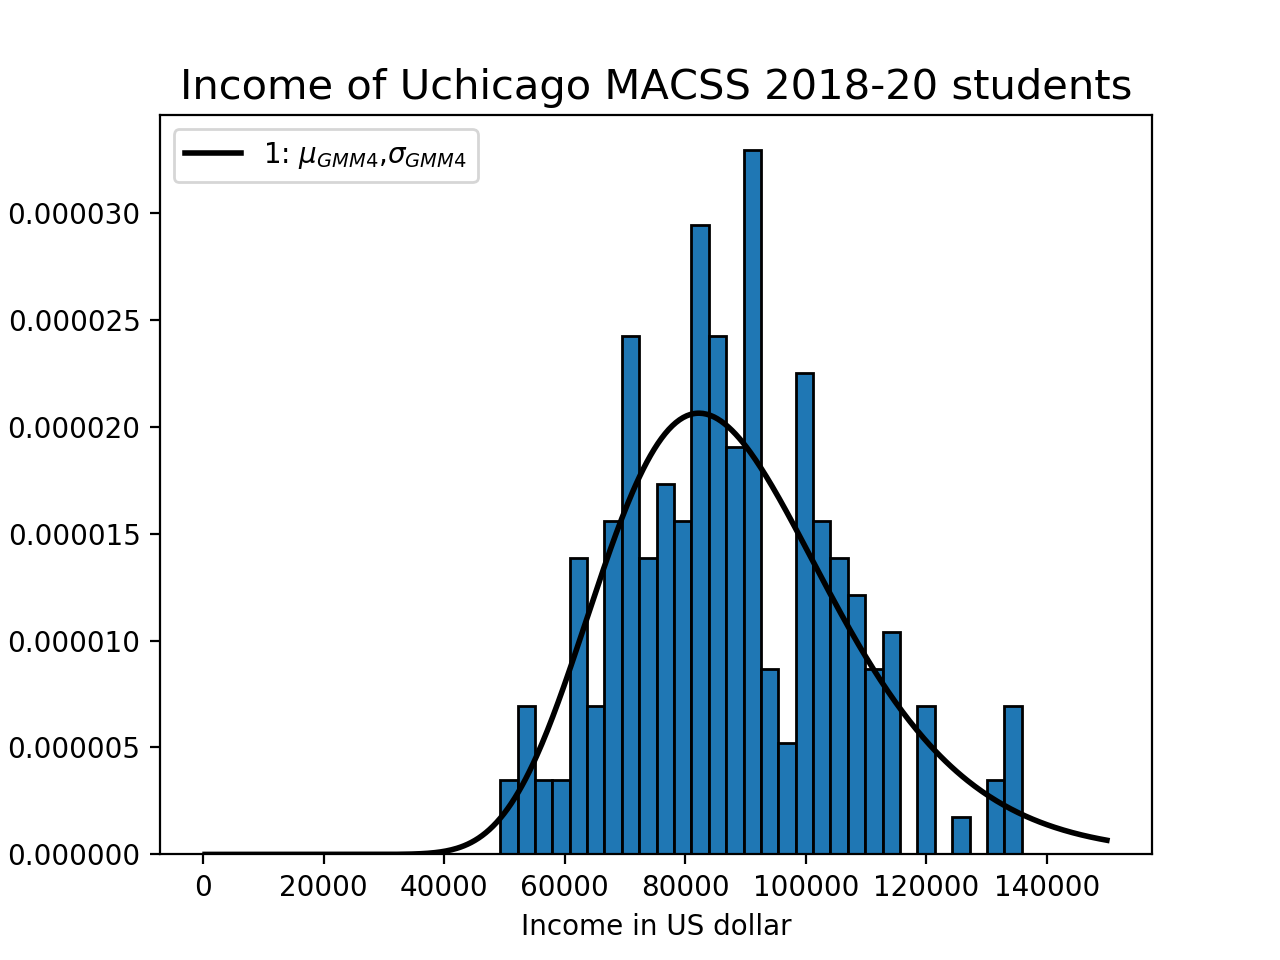

/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in log
/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in multiply


In [18]:
# Plot the histogram of the data
count, bins, ignored = plt.hist(income, 30, edgecolor='black', normed=True)
plt.title('Income of Uchicago MACSS 2018-20 students', fontsize=15)
plt.xlabel('Income in US dollar')
plt.ylabel('Percent of students')

# Plot the estimated GMM PDF
dist_pts = np.linspace(0, 150000, 500)
plt.plot(dist_pts, trunc_norm_pdf(dist_pts, mu_GMM1_4, sig_GMM1_4, 450),
         linewidth=2, color='k', label='1: $\mu_{GMM4}$,$\sigma_{GMM4}$')
plt.legend(loc='upper left')
plt.show()

(e)

In [19]:
err1_4 = err_vec4(income, mu_GMM1_4, sig_GMM1_4, 150000, False)
print(err1_4)
VCV2_4 = np.dot(err1_4, err1_4.T) / income.shape[0]
print(VCV2_4)
W_hat2_4 = lin.pinv(VCV2_4)  # Use the pseudo-inverse calculated by SVD because VCV2 is ill-conditioned
print(W_hat2_4)

[[-0.64071978]
 [-1.02752217]
 [-0.6748936 ]]
[[ 0.00205261  0.00329177  0.00216209]
 [ 0.00329177  0.00527901  0.00346734]
 [ 0.00216209  0.00346734  0.00227741]]
[[ 22.23041722  35.65091527  23.41611211]
 [ 35.65091527  57.17336507  37.55241391]
 [ 23.41611211  37.55241391  24.66504794]]


In [20]:
mu_init = 11
sig_init = 0.5
params_init = np.array([mu_GMM1_4, sig_GMM1_4])
gmm_args = (income, 150000, W_hat2_4)
results2_4 = opt.minimize(criterion4, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2_4, sig_GMM2_4 = results2_4.x
print('mu_GMM2_4=', mu_GMM2_4, ' sig_GMM2_4=', sig_GMM2_4)
crit_val = criterion4(np.array([mu_GMM1_4, sig_GMM1_4]), income, 150000, W_hat2_4)
results2_4
print("The value of criterion function is", crit_val)
print("Data moments are: ", data_moments4(income))
print("Model moments are: ", model_moments4(mu_GMM2_4, sig_GMM2_4, 150000))

mu_GMM2_4= 11.3702304616  sig_GMM2_4= 0.228975255285
The value of criterion function is [[ 200.]]
Data moments are:  (0.265, 0.475, 0.26)
Model moments are:  (0.2633016120787548, 0.4701184284117203, 0.25824642531072123)


<IPython.core.display.Javascript object>


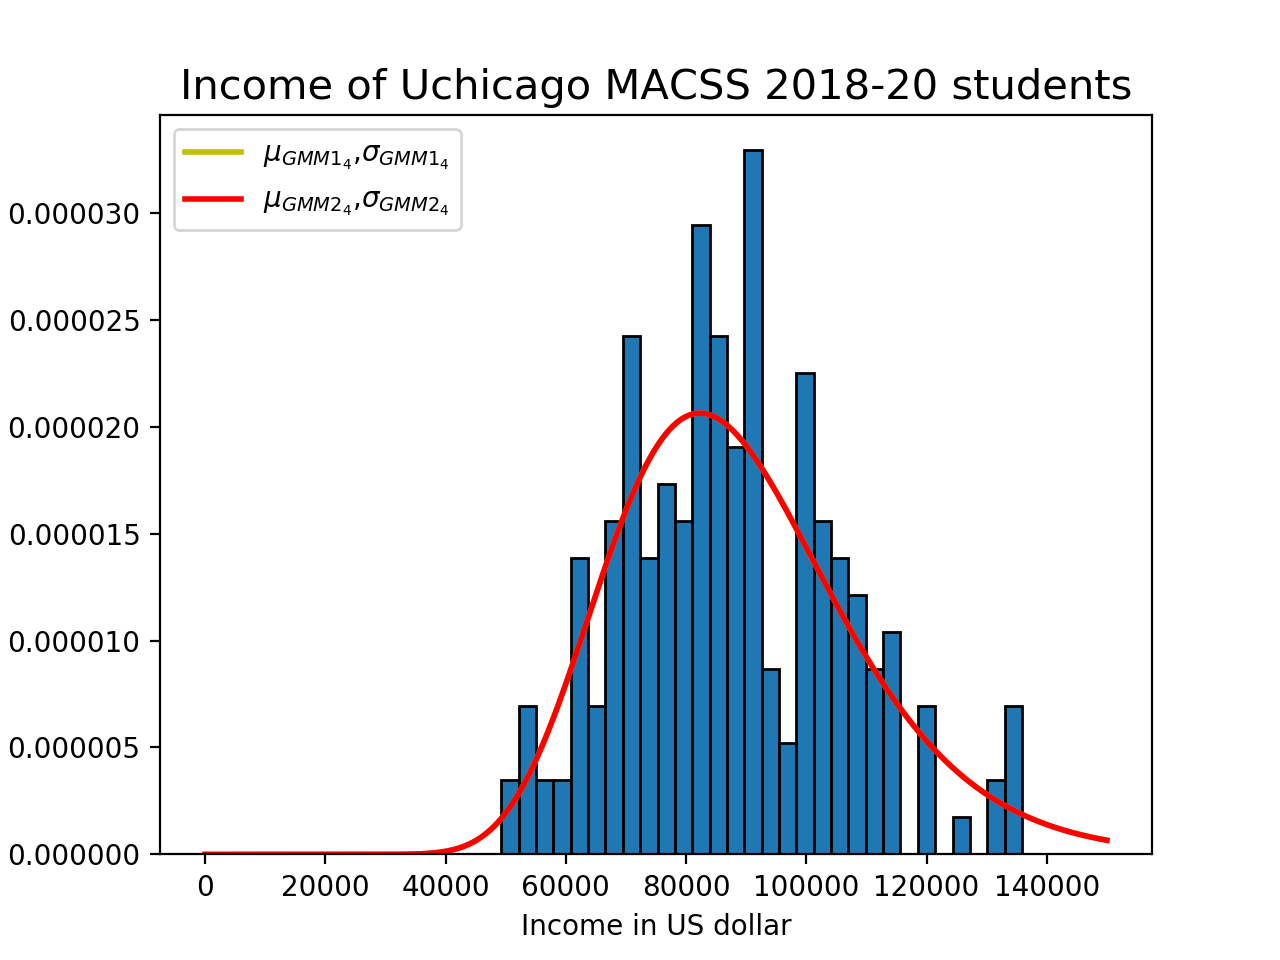

In [21]:
# histogram from part(a)
%matplotlib notebook
count, bins, ignored = plt.hist(income, 30, edgecolor='black', normed=True)
plt.title('Income of Uchicago MACSS 2018-20 students', fontsize=15)
plt.xlabel('Income in US dollar')
plt.ylabel('Percent of students')


# Plot the GMM estimated distribution from part (d)
dist_pts = np.linspace(1e-10, 150000, 500)
plt.plot(dist_pts, trunc_norm_pdf(dist_pts, mu_GMM1_4, sig_GMM1_4, 150000),
         linewidth=2, color='y', label='$\mu_{GMM1_4}$,$\sigma_{GMM1_4}$')
plt.legend(loc='upper left')

# Plot the two-step GMM estimated distribution
dist_pts = np.linspace(1e-10, 150000, 500)
plt.plot(dist_pts, trunc_norm_pdf(dist_pts, mu_GMM2_4, sig_GMM2_4, 150000),
         linewidth=2, color='r', label='$\mu_{GMM2_4}$,$\sigma_{GMM2_4}$')
plt.legend(loc='upper left')

(f)

The four estimations are all very good because their model moments are all very close to data moments.

Question 2

(a)

In [22]:
import pandas as pd

In [23]:
data = pd.read_csv('sick.txt')
sick = data['sick']
age = data['age']
children = data['children']
avg_temp = data['avgtemp_winter']
n = len(sick)

In [24]:
moms_data = sick.values
n = len(moms_data)
W = np.eye(200)

In [25]:
def model_moments(parameters):
    '''
    --------------------------------------------------------------------
    This function computes the model moments for GMM.
    --------------------------------------------------------------------
    Inputs: parameters
    
    Reuturn: moment of model
    --------------------------------------------------------------------
    '''
    b0, b1, b2, b3 = parameters
    moms_model = np.array([])
    for i in range(0, n):
        moms_model = np.append(moms_model, b0 + b1 * age[i] + b2 * children[i] + b3 * avg_temp[i])
    return moms_model

def err_vec(parameters, simple):
    '''
    --------------------------------------------------------------------
    This function computes the error  for GMM.
    --------------------------------------------------------------------
    Inputs: parameters and a boolean for simple
    
    Reuturn: error of the model
    --------------------------------------------------------------------
    '''
    b0, b1, b2, b3 = parameters
    moms_model = model_moments(parameters)
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

def criterion(parameters, *args):
    '''
    --------------------------------------------------------------------
    This function computes the GMM weighted sum of squared moment errors
    criterion function value given parameter values and an estimate of
    the weighting matrix.
    --------------------------------------------------------------------
    INPUTS:
    params = vector, ([b0, b1, b2, b3])
    args = (sick, W)
    W  = (R, R) matrix, estimate of optimal weighting matrix
    
    RETURNS: crit_val
    --------------------------------------------------------------------
    '''
    b0, b1, b2, b3 = parameters
    err = err_vec(parameters, simple=True)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

In [169]:
b = ((None, None), (None, None), (None, None), (None, None))
b0_init = 0
b1_init = 0
b2_init = 0
b3_init = 0
params_init = np.array([b0_init, b1_init, b2_init, b3_init])
results = opt.minimize(criterion, params_init, args = (sick, W), method='L-BFGS-B', bounds=b)
b0, b1, b2, b3 = results.x

In [170]:
print("GMM estimate for beta0 is", b0, ", beta1 is", b1, ", beta 2 is", b2, "beta 3 is", b3)

GMM estimate for beta0 is 0.251645437572 , beta1 is 0.0129335422436 , beta 2 is 0.400500401025 beta 3 is -0.00999176584737


In [171]:
crit_val = criterion(np.array([b0, b1, b2, b3]), (sick, W))
print("The value of the criterion function is", crit_val)

The value of the criterion function is 0.00182128980861
